In [9]:
# load the dataset from my github
!rm -rf CSE713
!git clone https://github.com/Ahnaf0171/CSE713.git


Cloning into 'CSE713'...
remote: Enumerating objects: 785, done.
remote: Total 785 (delta 0), reused 0 (delta 0), pack-reused 785 (from 2)
Receiving objects: 100% (785/785), 98.04 MiB | 37.29 MiB/s, done.
Resolving deltas: 100% (3/3), done.


/tmp/ipython-input-10-2557208306.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


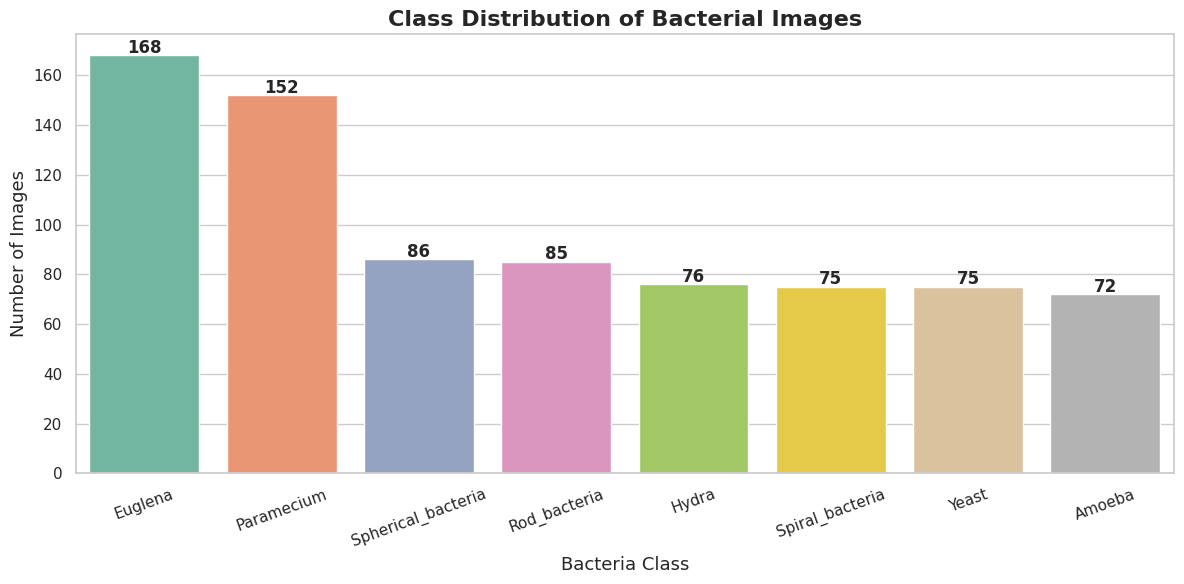

In [10]:
#class count visualization
import os
import matplotlib.pyplot as plt
import seaborn as sns

base_path = "/content/CSE713/Dataset/Micro_Organism"

class_counts = {}
for class_name in os.listdir(base_path):
    class_folder = os.path.join(base_path, class_name)
    if os.path.isdir(class_folder):
        count = len([
            f for f in os.listdir(class_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        class_counts[class_name] = count

class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", len(class_counts))

barplot = sns.barplot(
    x=list(class_counts.keys()),
    y=list(class_counts.values()),
    palette=colors
)

for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.,
        height + 1,
        int(height),
        ha="center",
        fontsize=12,
        fontweight='bold'
    )

plt.title("Class Distribution of Bacterial Images", fontsize=16, fontweight='bold')
plt.xlabel("Bacteria Class", fontsize=13)
plt.ylabel("Number of Images", fontsize=13)
plt.xticks(rotation=20)
plt.tight_layout()

plt.savefig("class_distribution_plot.png", dpi=300)

plt.show()


In [11]:
# Remove duplicate and blurry image
!pip install imagehash Pillow opencv-python

import os
import imagehash
from PIL import Image
import cv2
from collections import defaultdict

dataset_path = "/content/CSE713/Dataset/Micro_Organism"

hashes = defaultdict(list)
duplicate_paths = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    img_hash = imagehash.phash(img)
                    if img_hash in hashes:
                        duplicate_paths.append(img_path)
                    else:
                        hashes[img_hash].append(img_path)
            except:
                pass

for dup_path in duplicate_paths:
    os.remove(dup_path)

blurry_threshold = 100
blurry_images = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                variance = cv2.Laplacian(gray, cv2.CV_64F).var()
                if variance < blurry_threshold:
                    blurry_images.append((img_path, variance))
            except:
                pass

for path, score in blurry_images:
    os.remove(path)

print("Total blurry images removed:", len(blurry_images))



Total blurry images removed: 175


In [12]:

# Stratified_train_test_split_and_label_encoding_for_imbalanced_dataset
import os
import glob
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

dataset_path = "/content/CSE713/Dataset/Micro_Organism"
output_base = "/content/CSE713/Processed_Dataset"

train_dir = os.path.join(output_base, "train")
test_dir = os.path.join(output_base, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Step 1: Collect all image paths and corresponding class labels
image_paths = []
labels = []

all_classes = os.listdir(dataset_path)

for class_name in all_classes:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        image_paths.append(img_path)
        labels.append(class_name)

# Step 2: Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Create label map
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Step 3: Stratified Train-Test Split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Step 4: Copy images to their respective folders (same as before)
def copy_images(image_paths, labels, target_dir):
    for img_path, label in zip(image_paths, labels):
        label_folder = os.path.join(target_dir, label)
        os.makedirs(label_folder, exist_ok=True)
        shutil.copy(img_path, label_folder)

copy_images(train_paths, train_labels, train_dir)
copy_images(test_paths, test_labels, test_dir)

print("✅ Stratified train-test split done.")
print("📌 Class to label mapping:", label_map)


✅ Stratified train-test split done.
📌 Class to label mapping: {np.str_('Amoeba'): np.int64(0), np.str_('Euglena'): np.int64(1), np.str_('Hydra'): np.int64(2), np.str_('Paramecium'): np.int64(3), np.str_('Rod_bacteria'): np.int64(4), np.str_('Spherical_bacteria'): np.int64(5), np.str_('Spiral_bacteria'): np.int64(6), np.str_('Yeast'): np.int64(7)}


In [13]:
# Resize , normalize image sharpness and contrast (FOR ONLY TRAINING DATASET)
import os
import numpy as np
from PIL import Image, ImageEnhance
from tqdm import tqdm

def calculate_mean_std(image_dir, image_size=(224, 224)):
    means = []
    stds = []

    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0
                img_array = img_array.reshape(-1, 3)

                means.append(np.mean(img_array, axis=0))
                stds.append(np.std(img_array, axis=0))
            except Exception as e:
                print(f"Skipping {img_path}: {e}")

    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)

    return mean, std

def preprocess_training_images(input_dir, output_dir, mean, std, image_size=(224, 224)):
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_input_path = os.path.join(input_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        for img_name in tqdm(os.listdir(class_input_path), desc=f"Preprocessing {class_name}"):
            img_path = os.path.join(class_input_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
                image = image.resize(image_size)
                image = ImageEnhance.Sharpness(image).enhance(1.5)
                image = ImageEnhance.Contrast(image).enhance(1.2)
                img_array = np.array(image) / 255.0
                img_array = (img_array - mean) / std
                img_array = ((img_array * std + mean) * 255).clip(0, 255).astype(np.uint8)
                processed_image = Image.fromarray(img_array)
                processed_image.save(os.path.join(class_output_path, img_name))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

train_input_dir = "/content/CSE713/Processed_Dataset/train"
train_output_dir = "/content/CSE713/Processed_Train"

mean, std = calculate_mean_std(train_input_dir)
print("✅ Dataset Mean:", mean)
print("✅ Dataset Std:", std)

preprocess_training_images(train_input_dir, train_output_dir, mean, std)
print("✅ Preprocessing completed successfully.")


Processing Paramecium: 100%|██████████| 94/94 [00:02<00:00, 45.32it/s]


✅ Dataset Mean: [0.53630386 0.55018798 0.55028092]
✅ Dataset Std: [0.17795947 0.18133985 0.1802443 ]


Preprocessing Paramecium: 100%|██████████| 94/94 [00:03<00:00, 31.23it/s]

✅ Preprocessing completed successfully.


In [14]:
#Resize and normalize for test dataset but using training data parameter
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def preprocess_test_images(input_dir, output_dir, mean, std, image_size=(224, 224)):
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_input_path = os.path.join(input_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        for img_name in tqdm(os.listdir(class_input_path), desc=f"Preprocessing {class_name}"):
            img_path = os.path.join(class_input_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
                image = image.resize(image_size)
                img_array = np.array(image) / 255.0
                img_array = (img_array - mean) / std
                img_array = ((img_array * std + mean) * 255).clip(0, 255).astype(np.uint8)
                processed_image = Image.fromarray(img_array)
                processed_image.save(os.path.join(class_output_path, img_name))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

test_input_dir = "/content/CSE713/Processed_Dataset/test"
test_output_dir = "/content/CSE713/Processed_Test"

mean = np.array([0.50151639, 0.51555528, 0.51724466])
std = np.array([0.19444162, 0.19618673, 0.19317427])

preprocess_test_images(test_input_dir, test_output_dir, mean, std)
print("✅ Test set preprocessing completed successfully.")



Preprocessing Paramecium: 100%|██████████| 24/24 [00:00<00:00, 42.29it/s]

✅ Test set preprocessing completed successfully.


In [15]:
# Smart Data Augmentation (only for training data)
import os
import cv2
import random
import albumentations as A
from tqdm import tqdm


train_dir = "/content/CSE713/Processed_Dataset/train"


aug = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=25, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.MotionBlur(blur_limit=5, p=0.2),
    A.RandomGamma(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.CLAHE(p=0.2),
    A.RandomShadow(p=0.2),
])


for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    images = os.listdir(class_path)

    for img_name in tqdm(images, desc=f"Augmenting {class_folder}"):
        img_path = os.path.join(class_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for i in range(2):  # augment 2x per image (you can change this)
            augmented = aug(image=image)
            aug_image = augmented['image']
            aug_image = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)

            aug_name = f"aug_{i}_{img_name}"
            cv2.imwrite(os.path.join(class_path, aug_name), aug_image)



Augmenting Paramecium: 100%|██████████| 94/94 [00:07<00:00, 12.31it/s]
